In [1]:
import threading
import progressbar
import time
from progressbar import Bar, ETA, Percentage, ProgressBar, SimpleProgress
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from dataset import Dataset, DLoader
from ops import *
from model import create_netD, create_netG, my_init
from os import makedirs
from os.path import exists
from config import config
from random import randint
from skimage.measure import compare_ssim as ssim
from sklearn.metrics import jaccard_similarity_score
import cv2

Using TensorFlow backend.


#### load data

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)

sess = tf.Session()
K.set_session(sess)

dataset = 'product_gm'
ngf = 64
ndf = 64
batch_size = config['batch_size']

# data = Dataset(dataset=dataset, batch_size=batch_size, thread_num=1)
data = DLoader(config)

(train_X, train_y) = data.get_inputs()

# test_img, test_label = load_image('./datasets/%s/val/%d.jpg' % (dataset, 1))

test_imgs, test_labels = data.get_batch_imgs()
train_imgs, train_labels = data.get_batch_imgs(train=True)

img_shape, label_shape = data.get_shape()

image_width = img_shape[1]
image_height = img_shape[0]
output_channel = label_shape[2]
input_channel = img_shape[2]

print(img_shape, label_shape)

Batch size: 4, Thread num: 1
load dataset done
data size: 33552
in shape: [256, 256, 3] label shape: [256, 256, 3]
[256, 256, 3] [256, 256, 3]


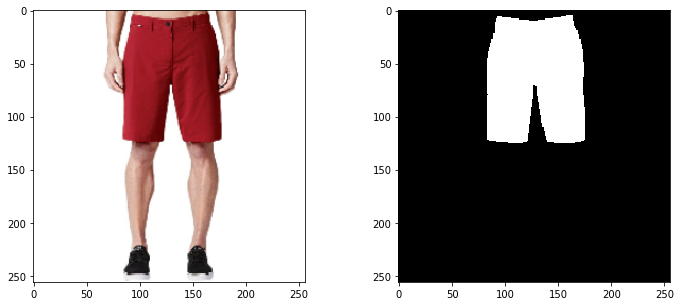

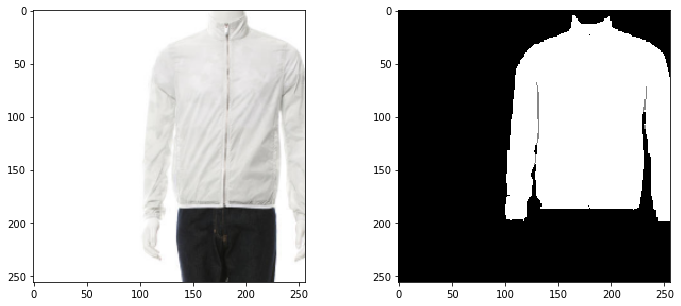

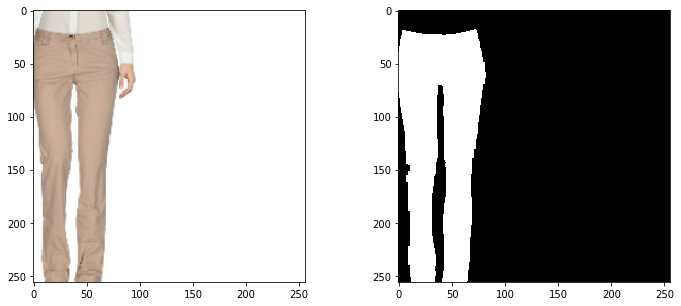

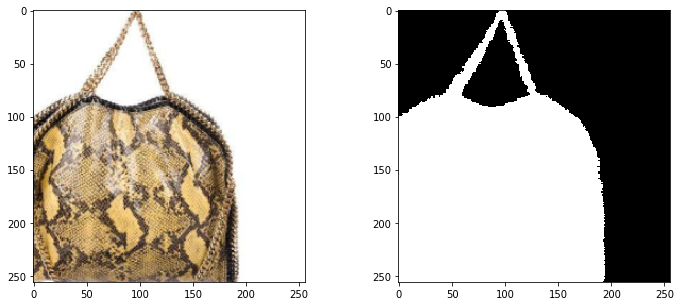

In [3]:
train_imgs, train_labels = data.get_batch_imgs(train=True)
plot_batch(train_imgs, train_labels, batch_size)

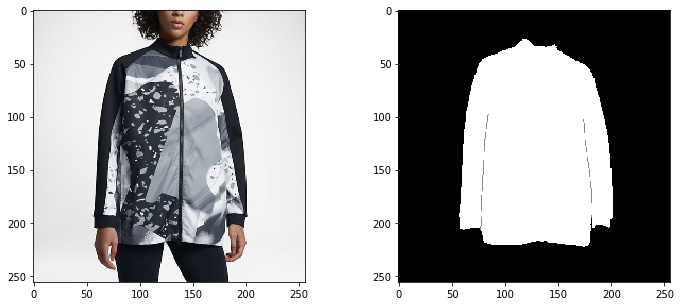

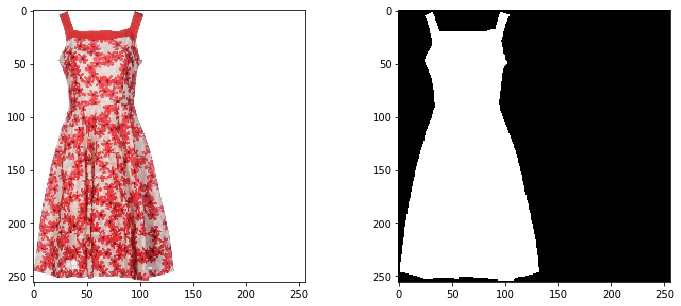

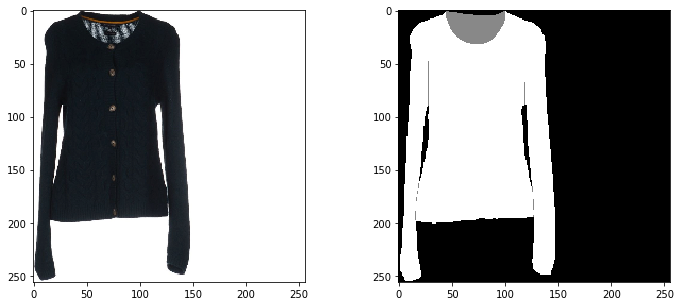

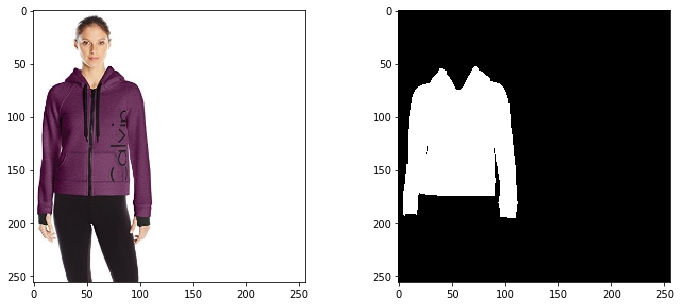

In [4]:
plot_batch(test_imgs, test_labels, batch_size)

In [10]:
np.unique(test_label)

array([  0, 135, 255], dtype=uint8)

In [3]:
print(test_img.shape, test_label.shape)

(256, 256, 3) (256, 256, 3)


In [21]:
import imp
import ops
imp.reload(ops)
from ops import *

In [7]:
import imp
import model
imp.reload(model)
from model import create_netD, create_netG, my_init

In [5]:
#encoder_decoder

#### define architechture

In [5]:
# Generator
# U-NET
# CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
tmp_x = tf.placeholder(tf.float32, [None, image_width, image_height, input_channel])
test_x = tf.placeholder(tf.float32, [1, image_width, image_height, input_channel])

d_in_shape = (image_width, image_height, input_channel+output_channel)
g_in_shape = (image_width, image_height, input_channel)

D = create_netD(d_in_shape, ndf, 3)
dec_output, generated_img, encoder_decoder = create_netG(train_X, tmp_x, ngf, 3, g_in_shape, output_channel, batch_size)

/home/avi/src/pix2pix/model.py:184: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), strides=(2, 2), kernel_initializer=<keras.ini..., padding="same")`
  padding="same"
/home/avi/src/pix2pix/model.py:205: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), strides=(2, 2), kernel_initializer=<keras.ini..., padding="same")`
  padding="same"
/home/avi/src/pix2pix/model.py:225: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), strides=(2, 2), kernel_initializer=<keras.ini..., padding="same")`
  padding="same"
/home/avi/src/pix2pix/model.py:245: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (3, 3), strides=(2, 2), kernel_initializer=<keras.ini..., padding="same")`
  padding="same"
/home/avi/src/pix2pix/model.py:264: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(256, (3

In [6]:
# ## Objective function
d_lr = tf.placeholder(tf.float32)
g_lr = tf.placeholder(tf.float32)

loss_d = tf.reduce_mean(tf.log(D(concat(train_X, train_y)) + 1e-12)) +\
tf.reduce_mean(tf.log(1 - D(concat(train_X, dec_output)) + 1e-12))

loss_g_1 = tf.reduce_mean(tf.log(1 - D(concat(train_X, dec_output)) + 1e-12))
loss_g_2 = tf.reduce_mean(tf.abs(train_y - dec_output))
loss_g = loss_g_1 + 100. * loss_g_2


# ## Optimizer
train_d = tf.train.AdamOptimizer(d_lr, beta1=0.5).minimize(
    -loss_d, var_list=D.trainable_weights)

train_g = tf.train.AdamOptimizer(
    g_lr, beta1=0.5).minimize(
    loss_g, var_list=[op for l in map(lambda x: x.trainable_weights, encoder_decoder) for op in l])

#### load or initialize

In [7]:
last_chkp = './model/'+dataset+'/model_4.7952_0.9231.ckpt-32'
last_chkp = 'last'
saver = tf.train.Saver()
if last_chkp == '':
    sess.run(tf.global_variables_initializer())
    last_epoch = 0
    print('initialized new session. chkp #', last_epoch)
else:
    if last_chkp == 'last':
        try:
            last_chkp = tf.train.latest_checkpoint('./model/'+dataset+'/')          
        except:
            pass
    last_epoch = int(last_chkp.split('-')[-1])
    saver.restore(sess, last_chkp)   
    print('loaded session. chkp #', last_epoch)
    
tb_path = '/home/avi/data/logs/pix2pix/TB'
writer = tf.summary.FileWriter(tb_path, sess.graph)
loss_d_sum = tf.summary.scalar('loss_d', loss_d)
loss_g_sum = tf.summary.scalar('loss_g', loss_g)
# hist_summary = tf.summary.histogram('dec_out', dec_output)
# merged = tf.summary.merge_all()

INFO:tensorflow:Restoring parameters from ./model/product_gm/model_4.4420_0.9231.ckpt-55
loaded session. chkp # 55


In [7]:
data.get_size()

33552

In [17]:
nb_epochs = 200
SETPS_IN_EPOCH = data.get_size() - 1
# SETPS_IN_EPOCH = 5000
eval_every = 1
save_imgs = True
last_eval = 0.923105

run_d_lr = run_g_lr = 1e-7

#tf.train.start_queue_runners(sess=sess)
data.start_threads(sess)

mkdir('./model')
save_root = './output_imgs/' + dataset
if not exists(save_root):
    makedirs(save_root)

# Training
widgets = ['Train: ', Percentage(), '(', SimpleProgress(), ') ',Bar(marker='#', left='[', right=']'), ' ', ETA()]
ssim_widgets = ['Evaluate: ', Percentage(), '(', SimpleProgress(), ') ',Bar(marker='*', left='[', right=']'), ' ', ETA()]

pbar = ProgressBar(widgets=widgets, maxval=SETPS_IN_EPOCH)
total_batches = len(data.val_data)//batch_size
ssim_pbar = ProgressBar(widgets=ssim_widgets, maxval=total_batches*batch_size)

for i in range(last_epoch, last_epoch+nb_epochs):
    ave_d, ave_g = [], []
    print('start training')
    
    pbar.start()

    for j in range(SETPS_IN_EPOCH):
        sess.run(train_d, feed_dict={K.learning_phase(): 1, d_lr: run_d_lr})
        sess.run(train_g, feed_dict={K.learning_phase(): 1, g_lr: run_g_lr})

        loss_d_val, sum_d  = sess.run([loss_d, loss_d_sum], feed_dict={K.learning_phase(): 1})
        writer.add_summary(sum_d)
        ave_d.append(loss_d_val)
        loss_g_val, sum_g = sess.run([loss_g,loss_g_sum], feed_dict={K.learning_phase(): 1})
        writer.add_summary(sum_g)
        ave_g.append(loss_g_val)
        time.sleep(1e-8)
        pbar.update(j)
    
#     summary = sess.run(merged, feed_dict={K.learning_phase(): 1})
#     writer.add_summary(summary)
    pbar.finish()

    print("Epoch %d/%d - dis_loss: %g - gen_loss: %g" % (i+1, last_epoch+nb_epochs, np.mean(ave_d), np.mean(ave_g)))


    if save_imgs:
        generated_image = sess.run(generated_img, feed_dict={tmp_x: test_imgs, K.learning_phase(): 1})
        for j in range(config['batch_size']):
            score = ssim(generated_image[j], test_labels[j], multichannel=True)
            save_image(generated_image[j], './output_imgs/' + dataset+'_val' , i+1, j, score)
#         val_gens_summary = tf.summary.image('test_gens', generated_image, max_outputs=batch_size)
#         val_imgs_summary = tf.summary.image('test_imgs', tmp_x, max_outputs=batch_size)
        
        generated_image = sess.run(generated_img, feed_dict={tmp_x: train_imgs, K.learning_phase(): 1})
        for j in range(config['batch_size']):
            score = ssim(generated_image[j], train_labels[j], multichannel=True)
            save_image(generated_image[j], './output_imgs/' + dataset+'_train' , i+1, j, score)
    
    
    # evaluate SSIM
    if i+1 > last_epoch and (i+1-last_epoch)%eval_every == 0:
        avg_ssim = 0
        
        tot_amount = len(data.val_data)

        ssim_pbar.start()
        
        for k in range(0, total_batches*batch_size, batch_size):
            x = data.val_data[k:k+batch_size]
#             if k%(tot_amount//4) == 0:
#                 print('completed {:.1f}%({}) batches of total {}'.format(k/tot_amount*100, k, tot_amount))
            val_imgs, val_labels = [], []
            if len(x) != batch_size:
                tot_amount -= len(x)
            else:
                for l in range(batch_size):
                    val_img, val_label = data.get_img_label(data.val_data[k+l], augment=False)
                    val_imgs.append(val_img)
                    val_labels.append(val_label)
                val_gen_images = sess.run(generated_img, feed_dict={tmp_x: val_imgs, K.learning_phase(): 1})
                
                for l in range(batch_size):
                    avg_ssim += ssim(val_gen_images[l], val_labels[l], multichannel=True)
            time.sleep(1e-8)
            ssim_pbar.update(k)
        avg_ssim /= tot_amount
        ssim_pbar.finish()
        print('Epoch: {}, D_LR:{}, G_LR:{}, avg_ssim:{:.5} for {} val images'.format(
            i+1, run_d_lr, run_g_lr, avg_ssim, tot_amount))
        
        if avg_ssim > last_eval:
            save_path = './model/{}/model_{}_{}.ckpt'.format(dataset, str(np.mean(ave_g))[:6], str(avg_ssim)[:6])
            saver.save(sess, save_path, global_step=i+1)
            last_eval = avg_ssim
            print('saved chkp to path:', save_path)

start training


Train: 100%(5000 of 5000) [#####################################] Time: 0:10:22
/home/avi/.local/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


Epoch 56/255 - dis_loss: -0.00375679 - gen_loss: 4.42773


Evaluate: 100%(4192 of 4192) [**********************************] Time: 0:01:42


Epoch: 56, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92263 for 4194 val images
start training


Epoch 57/255 - dis_loss: -0.00440836 - gen_loss: 4.41355


Epoch: 57, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92288 for 4194 val images
start training


Epoch 58/255 - dis_loss: -0.00400777 - gen_loss: 4.43575


Epoch: 58, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92294 for 4194 val images
start training


Epoch 59/255 - dis_loss: -0.0041489 - gen_loss: 4.41364


Epoch: 59, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92301 for 4194 val images
start training


Epoch 60/255 - dis_loss: -0.00379524 - gen_loss: 4.43092


Epoch: 60, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92301 for 4194 val images
start training


Epoch 61/255 - dis_loss: -0.00415089 - gen_loss: 4.44188


Epoch: 61, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92276 for 4194 val images
start training


Epoch 62/255 - dis_loss: -0.00388966 - gen_loss: 4.385


Epoch: 62, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.923 for 4194 val images
start training


Epoch 63/255 - dis_loss: -0.00361341 - gen_loss: 4.37268


Epoch: 63, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92305 for 4194 val images
start training


Epoch 64/255 - dis_loss: -0.00373481 - gen_loss: 4.38602


Epoch: 64, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92273 for 4194 val images
start training


Epoch 65/255 - dis_loss: -0.00390939 - gen_loss: 4.39159


Epoch: 65, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92311 for 4194 val images


saved chkp to path: ./model/product_gm/model_4.3915_0.9231.ckpt
start training


Epoch 66/255 - dis_loss: -0.0038255 - gen_loss: 4.34196


Epoch: 66, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92301 for 4194 val images
start training


Epoch 67/255 - dis_loss: -0.00401669 - gen_loss: 4.40835


Epoch: 67, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.9231 for 4194 val images
start training


Epoch 68/255 - dis_loss: -0.00363273 - gen_loss: 4.37429


Epoch: 68, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.9228 for 4194 val images
start training


Epoch 69/255 - dis_loss: -0.00367846 - gen_loss: 4.4064


Epoch: 69, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92303 for 4194 val images
start training


Epoch 70/255 - dis_loss: -0.0039793 - gen_loss: 4.39529


Epoch: 70, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92312 for 4194 val images


saved chkp to path: ./model/product_gm/model_4.3952_0.9231.ckpt
start training


Epoch 71/255 - dis_loss: -0.00412019 - gen_loss: 4.43667


Epoch: 71, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92309 for 4194 val images
start training


Epoch 72/255 - dis_loss: -0.00383137 - gen_loss: 4.36909


Epoch: 72, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92293 for 4194 val images
start training


Epoch 73/255 - dis_loss: -0.00369424 - gen_loss: 4.43238


Epoch: 73, D_LR:1e-07, G_LR:1e-07, avg_ssim:0.92256 for 4194 val images
start training


Epoch 74/255 - dis_loss: -0.00377032 - gen_loss: 4.39186


KeyboardInterrupt: 

In [ ]:
# save_path = './model/{}/model_{}_{}.ckpt'.format(dataset, str(np.mean(ave_g))[:6], str(avg_ssim)[:6])
saver.save(sess, save_path, global_step=i+1)

#### eval SSIM

In [ ]:
avg_ssim = 0
total_batches = len(data.val_data)//batch_size
for k in range(0, len(data.val_data), batch_size):
    x = data.val_data[k:k+batch_size]
    if k%(total_batches/10) == 0:
        print('completed {:.2}%({}) batches of total {}'.format(k/total_batches*100, k, total_batches))
    val_imgs, val_labels = [], []
    for l in range(len(x)):
        val_img, val_label = data.get_img_label(data.val_data[k+l], augment=False)
        val_imgs.append(val_img)
        val_labels.append(val_label)
    val_gen_images = sess.run(generated_img, feed_dict={tmp_x: val_imgs, K.learning_phase(): 1})
    for l in range(batch_size):
        avg_ssim += ssim(val_gen_images[l], val_labels[l], multichannel=True)
avg_ssim /= len(data.val_data)
print('avg_ssim:', avg_ssim, 'for', len(data.val_data), 'val images')

completed 0.0%(0) batches of total 2097


In [9]:
label_vals = {}
label_vals['bg'] = [0,50]
label_vals['sep'] = [133,135]
label_vals['back'] = [136,140]
label_vals['gm'] = [200, 255]

def standardize_predict(predict):
    mask = cv2.cvtColor(predict, cv2.COLOR_BGR2GRAY)
    out_mask = np.zeros_like(mask)
    print(predict.shape, mask.shape)
    out_mask[mask>200] = 255
    out_mask[(mask<=140) & (mask>=136)] = 138
    out_mask[(mask>=133) & (mask<=135)] = 135
    return out_mask

#### Plot Predict

(256, 256, 3) (256, 256)
predict vals: [  0 135 138 255]


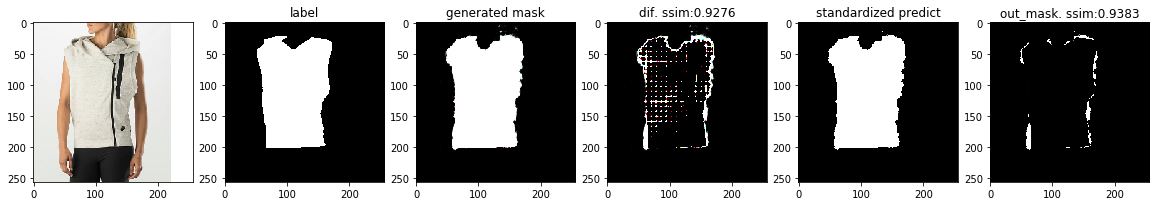

(256, 256, 3) (256, 256)
predict vals: [  0 135 138 255]


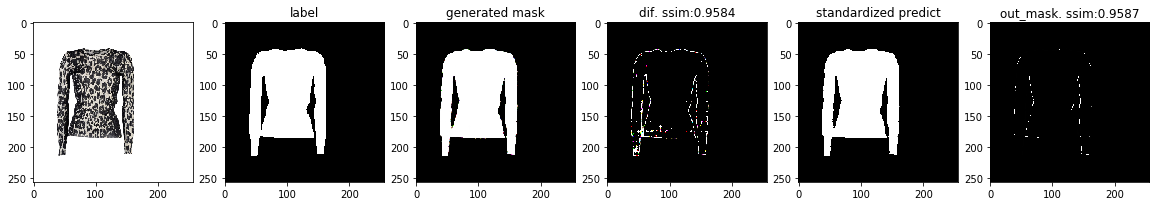

(256, 256, 3) (256, 256)
predict vals: [  0 135 138 255]


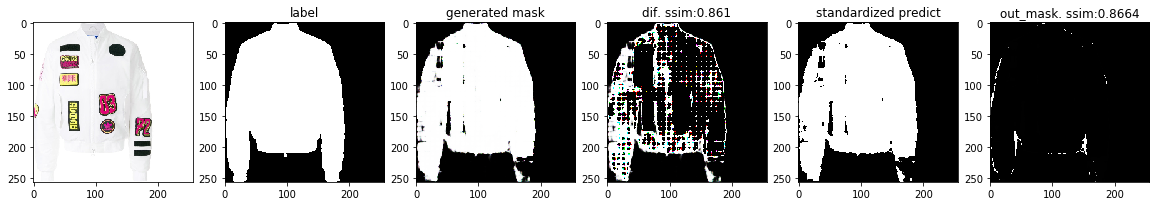

(256, 256, 3) (256, 256)
predict vals: [  0 135 138 255]


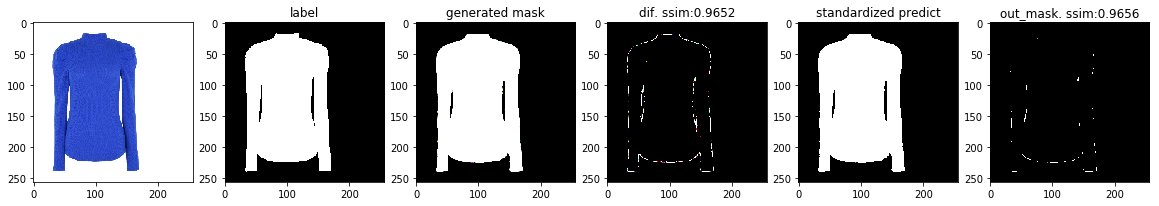

In [16]:
# test_img, test_label = data.get_img_label(data.val_data[randint(0, len(data.val_data)-1)])
test_imgs, test_labels, folders = data.get_batch_imgs(ret_names=True)
generated_images = sess.run(generated_img, feed_dict={tmp_x: test_imgs, K.learning_phase(): 1})


for i in range(batch_size):
    predict = unsclae_img(generated_images[i])
    label = unsclae_img(test_labels[i])
    mask = standardize_predict(predict)
        
    print('predict vals:', np.unique(mask))
    img_ssim = ssim(predict, label, multichannel=True)
    mask_ssim = ssim(mask, label[:,:,0])
#     iou = jaccard_similarity_score(mask, label[:,:,0], normalize = True)
    f, ax = plt.subplots(1, 6, figsize=(20,5))
    ax[0].imshow(unsclae_img(test_imgs[i][:,:,[2,1,0]]))
    ax[2].imshow(predict)
    ax[1].imshow(label)
    ax[3].imshow(predict-label)
    ax[4].imshow(mask, cmap='gray')
    ax[5].imshow(mask-label[:,:,0], cmap='gray')
#     ax[0].set_title('image '+os.path.split(folders[i])[1])
    ax[2].set_title('generated mask')
    ax[1].set_title('label')
    ax[3].set_title('dif. ssim:{:.4}'.format(img_ssim))
    ax[4].set_title('standardized predict')
    ax[5].set_title('out_mask. ssim:{:.4}'.format(mask_ssim))
    plt.show()